# Análisis Exploratorio de Sinietros Viales, Buenos Aires
En este documento elaboramos un análisis exploratorio de datos de siniestros viales en Buenos Aires, entre los años 2016 y 2021. El objetivo de comprender las características de los siniestros viales, como tendencias, correlaciones, estacionalidades, factores demográficos, entre otros. La información proviene de un dataset proporciónado por el [Observatorio de Movilidad y Seguridad Vial, CABA](https://data.buenosaires.gob.ar/es_AR/dataset/victimas-siniestros-viales).

Este notebook esta organizado en tres secciones:
1. Extracción, Transformación y Carga (ETL)
2. Análisis Estadístico y Visualizaciónes
3. Insights y Conclusión

---

# 1. Extracción, Transformación y Carga (ETL)

## Importación de Librerias

In [2]:
import os
import warnings
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point

In [3]:
# Ajuste de opciónes 
# Opción para ignorar advertencias, en este caso, principalmente de Pandas
warnings.filterwarnings('ignore')
# Opción para deshabilitar el limite de columnas mostradas
pd.set_option('display.max_columns', None)

## Carga de Datos

In [4]:
# Identificamos el URL de la fuente del dataset 'homicidios.xlsx'
dataset_url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/victimas-siniestros-viales/homicidios.xlsx'
# Cargamos, como dataframes, las hojas de 'homicidios.xlsx'
archivo = pd.ExcelFile(dataset_url)

dfs = {} # almacén de los dataframes resultantes
# Iteramos sobre cada nombre de hoja y almacenamos la hojas en 'dfs'
for hoja in archivo.sheet_names:
    dfs[hoja] = archivo.parse(hoja)

# Imprimimos las llaves de 'dfs', confirmando su contenido
dfs.keys()

dict_keys(['HECHOS', 'DICCIONARIO_HECHOS', 'VICTIMAS', 'DICCIONARIO_VICTIMAS', 'clas'])

In [5]:
# Asignamos a variables las dos tablas de interes.
df_hom_hechos: pd.DataFrame = dfs['HECHOS']
df_hom_victimas: pd.DataFrame = dfs['VICTIMAS']

Imprimimos una muestra del dataset, para ver como esta estructurado.

In [6]:
df_hom_hechos.sample(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
65,2016-0088,1,2016-07-11,2016,7,11,15:30:00,15,CERETTI Y NUÑEZ,CALLE,CERETTI,NaN,NU?EZ,CERETTI y NUÃ‘EZ,12,Point (96492.89040317 106832.19475660),-58.50151750,-34.56767549,PEATON-AUTO,PEATON,AUTO
156,2017-0017,1,2017-02-06,2017,2,6,08:00:00,8,AV. JUAN B JUSTO Y PARAGUAY,AVENIDA,"JUSTO, JUAN B. AV.",NaN,PARAGUAY,"JUSTO, JUAN B. AV. y PARAGUAY",14,Point (103145.91571023 105359.30690018),-58.42901200,-34.58095431,MOTO-AUTO,MOTO,AUTO
481,2019-0065,1,2019-08-08,2019,8,8,16:45:00,16,BARCO CENTENERA DEL Y TILCARA,CALLE,BARCO CENTENERA DEL,NaN,TILCARA,BARCO CENTENERA DEL y TILCARA,4,Point (103996.06089673 97239.27066069),-58.41970850,-34.65414867,PEATON-PASAJEROS,PEATON,PASAJEROS


In [7]:
df_hom_victimas.sample(3)

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
627,2021-0008,2021-01-22,2021,1,22,PEATON,PEATON,MASCULINO,28,2021-01-22 00:00:00
339,2018-0051,2018-05-15,2018,5,15,PEATON,PEATON,FEMENINO,57,2018-05-15 00:00:00
665,2021-0046,2021-05-31,2021,5,31,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,20,2021-05-31 00:00:00


Con los datos cargados, revisamos si exiten filas duplicadas.

In [8]:
# Imprimimos el conteo de duplicados en 'df_hom_hechos' y 'df_hom_victimas'
print(
    f'{df_hom_hechos.duplicated().sum()} duplicados en df_hom_hechos\n'
    f'{df_hom_victimas.duplicated().sum()} duplicados en df_hom_victimas'
)

0 duplicados en df_hom_hechos
0 duplicados en df_hom_victimas


- No existen datos duplicados.

## Transformación de Datos

El dicciónarario del datasets definen los valores `SD` como "Sin Datos". Estos valores son efectivamente nulos, y debemos asignarles valores nulos en los dataframes. Este sera nuestro primer paso, previo a la evaluación de datos nulos.

In [9]:
# Convertimos todo valor 'SD' a nulo
df_hom_hechos.replace('SD', None, inplace=True)
df_hom_victimas.replace('SD', None, inplace=True)

### Tabla Hechos: Datos Nulos


In [10]:
df_hom_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   695 non-null    object        
 7   HH                     695 non-null    object        
 8   LUGAR_DEL_HECHO        695 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

- En `df_hom_hechos` exiten valores nulos.

Inspecciónamos las columns con nulos mas de cerca:

In [11]:
# Almacenamos 'df_hom_hechos' como archivo CSV para inspecciónarlo visualmente
# Creamos la carpeta de almacen del CSV
dir_csv = 'data_csv'
os.makedirs(dir_csv, exist_ok=True)
# Guardamos el datafram como CSV en disco
df_hom_hechos[df_hom_hechos.isna().any(axis=1)].to_csv(f'{dir_csv}/hom_hechos_CON_NULOS.csv')

Imprimimos una muestra de las filas con datos nulos y revisamos el CSV extraido en el paso anterior.

In [12]:
df_hom_hechos[df_hom_hechos.isna().any(axis=1)].sample(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
591,2020-0072,1,2020-12-19,2020,12,19,03:30:00,3,"JUJUY AV. Y CARLOS, CALVO",AVENIDA,JUJUY AV.,NaN,"CALVO, CARLOS","JUJUY AV. y CALVO, CARLOS",3,Point (105547.81747951 100901.07129086),-58.40280471,-34.62113271,BICICLETA-AUTO,BICICLETA,AUTO
227,2017-0104,1,2017-08-25,2017,8,25,09:00:00,9,AV. 9 DE JULIO Y ESTADOS UNIDOS,AVENIDA,9 DE JULIO AV.,NaN,ESTADOS UNIDOS,9 DE JULIO AV. y ESTADOS UNIDOS,1,Point (107538.91933237 101188.13128502),-58.38109568,-34.61853244,PEATON-CARGAS,PEATON,CARGAS
553,2020-0033,1,2020-07-19,2020,7,19,06:25:00,6,"PAZ, GRAL. AV. Y DEL LIBERTADOR AV.",GRAL PAZ,"PAZ, GRAL. AV.",NaN,DEL LIBERTADOR AV.,"PAZ, GRAL. AV. y DEL LIBERTADOR AV.",13,Point (99620.34936816 110483.29286598),-58.46743471,-34.53476874,AUTO-OBJETO FIJO,AUTO,OBJETO FIJO


Porcentaje de Nulos

In [13]:
#  Imprimimos los porcentajes de nulos por columna, donde porcentaje > 0
hom_hechos_porcent_nulos = df_hom_hechos.isna().mean() * 100
hom_hechos_porcent_nulos = hom_hechos_porcent_nulos[hom_hechos_porcent_nulos.gt(0)]
hom_hechos_porcent_nulos

HORA                      0.143678
HH                        0.143678
LUGAR_DEL_HECHO           0.143678
Calle                     0.143678
Altura                   81.465517
Cruce                    24.568966
Dirección Normalizada     1.149425
VICTIMA                   1.293103
ACUSADO                   3.304598
dtype: float64

Observaciónes:
- Vemos que las columnas `Altura` y `Cruce` tienen una alto porcentaje de nulos.
- Basado en la inspección en formato CSV, `Altura` es un dato irrelevante a nuestra investigación.
- Tambien, veemos que `pos x` y `pos y` tiene datos nulos con valor `.`. Convertiremos estos a valores nulos reconocibles por Pandas.
- Al igual, existen strings con simbolos de " (doble-comillas). Lo eliminaremos para tener un formato de texto consistente.
- Redundancias: 
  - `PARTICIPANTES` es un conjunto de las columnas `VICTIMA` y `ACUSADO`.
  - `LUGAR_DEL_HECHO` y `Cruce` son datos redundate ya que podemos inferir las ubicaciónes por `Dirección Normalizada` y las cordinadas `pos x` y `pos y`.
  - Al igual, `XY (CABA)` es redundante ya que inferir la ubición con `pos x` y `pos y`.

### Tabla Hechos: Ajustes y Tranformaciónes

Basado en las observaciónes anteriores, y en la inspección del dataset, decidimos eliminar las columnas `LUGAR_DEL_HECHO`, `Altura`, `XY (CABA)`, `PARTICIPANTES`. Tambien, haremos ajustes y transformaciónes, detallados en el siguiente paso.

In [14]:
# Eliminamos columnas redundantes
df_hom_hechos.drop(columns=['LUGAR_DEL_HECHO', 'Altura', 'XY (CABA)', 'PARTICIPANTES'], inplace=True)

Asignamos nulos a filas que aparecen con valor `.` en columnas `pos x` y `pos y`.

In [15]:
# Convertimos valores de '.' a nulos
df_hom_hechos.replace('.', None, inplace=True)

Estandarizamos la columna `Cruce` a valores _'En Cruce'_ o _'No en Cruce'_, para facilitar la aplicación de filtros en su análisis.

In [16]:
# Convertimos valores de 'Cruce'
df_hom_hechos['Cruce'] = df_hom_hechos['Cruce'].notna().replace({True:'Sí', False:'No'})

Renombramos la columna `Dirección Normalizada` a `Dirección`, para ser mas facil de referir subsecuentemente.

In [17]:
# Renombramos 'Dirección Normalizada'
df_hom_hechos.rename(columns={'Dirección Normalizada': 'Dirección'}, inplace=True)

Por ultimo, eliminamos los `"` (doble-comillas) de todo string para mantener un formato consistente.

In [18]:
# Eliminamos doble-comillas de los strings en columnas 'Dirección' y 'Calle'
col_a_modificar = ['Dirección', 'Calle']
for col in col_a_modificar:
    df_hom_hechos[col] = df_hom_hechos[col].apply(lambda x: x.replace('"', '') if pd.notnull(x) else x)

Convertimos `COMUNA` a tipo string.

In [19]:
# Convertimos a string
df_hom_hechos['COMUNA'] = df_hom_hechos['COMUNA'].astype(str)
# Existen 'COMUNA' con valor 0, la descartamos
df_hom_hechos = df_hom_hechos[df_hom_hechos['COMUNA'] != '0']

#### Transformaciónes a Tipo de Calle

In [20]:
# Conteo de valores únicos en columna 'TIPO_DE_CALLE'
df_hom_hechos['TIPO_DE_CALLE'].value_counts()

TIPO_DE_CALLE
AVENIDA      429
CALLE        135
GRAL PAZ      65
AUTOPISTA     65
Name: count, dtype: int64

Observaciónes:
- `GRAL PAZ` se refiere a la Avenida General Paz.
- Un detalle importante, la Avenida General Paz es funciónalmente una autopista (referencia: https://es.wikipedia.org/wiki/Avenida_General_Paz).

De acorde a estas observaciónes, reemplazaremos los valores de `GRAL PAZ` con `AUTOPISTA`.

In [21]:
# Reemplazar 'GRAL PAZ' por 'AUTOPISTA' en columna 'TIPO_DE_CALLE'
df_hom_hechos['TIPO_DE_CALLE'] = df_hom_hechos['TIPO_DE_CALLE'].replace({'GRAL PAZ':'AUTOPISTA'})
df_hom_hechos['TIPO_DE_CALLE'].unique()

array(['AVENIDA', 'AUTOPISTA', 'CALLE'], dtype=object)

#### Transformaciónes a Datos de Fecha-Hora (DateTime)

##### Semestre

Para los KPI, requerimos una nueva columna con el numero de semestre del registro/hecho (1 representa el primer semestre, 2 representa el segundo).

In [22]:
# Creamos una columna con el numero correspondiente al semestre
df_hom_hechos['SEMESTRE'] = df_hom_hechos['MM'].apply(lambda x: 1 if x <= 6 else 2)

##### Dias de Semana

Creamos una nueva columna con los nombre de los dias de semana.

In [23]:
df_hom_hechos['DIA_DE_SEMANA'] = df_hom_hechos['FECHA'].dt.day_name()
df_hom_hechos['DIA_DE_SEMANA'].unique()

array(['Friday', 'Saturday', 'Sunday', 'Thursday', 'Monday', 'Wednesday',
       'Tuesday'], dtype=object)

In [24]:
# Traducimos los dias de semana, estan en ingles
df_hom_hechos['DIA_DE_SEMANA'] = df_hom_hechos['DIA_DE_SEMANA'] \
    .replace({
        'Monday': '₁ Lunes',
        'Tuesday': '₂ Martes',
        'Wednesday': '₃ Miércoles',
        'Thursday': '₄ Jueves',
        'Friday': '₅ Viernes',
        'Saturday': '₆ Sábado',
        'Sunday': '₇ Domingo'
})
# Conteo de valores unicos en columna 'DIA_DE_SEMANA'
df_hom_hechos['DIA_DE_SEMANA'].value_counts()

DIA_DE_SEMANA
₁ Lunes        106
₆ Sábado       103
₇ Domingo       99
₃ Miércoles     98
₂ Martes        98
₅ Viernes       96
₄ Jueves        94
Name: count, dtype: int64

##### Nombre del Mes

Creamos una nueva columna con el nombre del mes, abbreviados.

In [25]:
# Creamos columna 'MES', con la abreviación del nombre del mes
df_hom_hechos['MES'] = df_hom_hechos['MM'] \
    .replace({
        1: '₀₁ ENE',
        2: '₀₂ FEB',
        3: '₀₃ MAR',
        4: '₀₄ ABR',
        5: '₀₅ MAY',
        6: '₀₆ JUN',
        7: '₀₇ JUL',
        8: '₀₈ AGO',
        9: '₀₉ SEP',
        10: '₁₀ OCT',
        11: '₁₁ NOV',
        12: '₁₂ DIC'
})
# Conteo de valores unicos en la nueva columna 'MES'
df_hom_hechos['MES'].value_counts()

MES
₁₂ DIC    77
₁₁ NOV    66
₀₈ AGO    65
₀₁ ENE    62
₀₅ MAY    60
₀₆ JUN    58
₀₂ FEB    56
₀₃ MAR    51
₀₇ JUL    51
₁₀ OCT    51
₀₄ ABR    50
₀₉ SEP    47
Name: count, dtype: int64

##### Fecha-Hora

Vamos a crear una columna con la fecha y hora combinanda, de tipo datetime, para facilitar el análisis de serie de tiempo. En nuestro caso, solo nos interesa las columnas `FECHA` y `HH`. Nota: `HH` es un numero entero de la hora del registro/hecho. Esta resolución de tiempo (de hora en hora) de serie de tiempo es lo suficientemente preciso para nuestro análisis.

Nuestro primer paso es imputar o eliminar los valores nulos relaciónados a tiempo.

In [26]:
# Verificamos si aun existen nulos en columnas relaciónados a tiempo.
if df_hom_hechos['FECHA'].isna().any() or df_hom_hechos['HH'].isna().any():
    print(f'Nulos en "FECHA": {df_hom_hechos['FECHA'].isna().sum()}\n'
          f'Nulos en "HH": {df_hom_hechos['HH'].isna().sum()}')
else:
    print('No existen nulos en "FECHA" y "HH"')

Nulos en "FECHA": 0
Nulos en "HH": 1


In [27]:
# Imputamos el nulo en 'HH' con la hora media, manteniendo como tipo int
hora_media = df_hom_hechos['HH'].mean(skipna=True)
df_hom_hechos['HH'] = df_hom_hechos['HH'].fillna(hora_media)
df_hom_hechos['HH'] = df_hom_hechos['HH'].astype(int)

Procedemos a crear la columna `FECHA_HORA`, de tipo datetime.

In [28]:
# Creamos una columna de fecha y hora combinada
df_hom_hechos['FECHA_HORA'] = df_hom_hechos.apply(lambda row: row['FECHA'] + pd.Timedelta(hours=row['HH']), axis=1)

De ultimo, eliminamos las columnas de quedan redundantes por el paso anterior.

`FECHA` y `HORA` quedan redundantes. Las demas columnas relaciónadas a tiempo (ej.: `MM`, `DD`) serviven como datos-a-graficar en nuestro análisis.

In [29]:
df_hom_hechos.drop(['FECHA', 'HORA'], axis=1, inplace=True)

##### Franjas de Horas

Vamos a dividir las horas en 6 partes: `0h - 3h`, `4h - 7h`, `8h - 11h`, `12h - 15h`, `16h - 19h` y `20h - 23h`, con el motivo de no sobrecargar visialmente la graficas que se produciran posteriormente.

In [30]:
# Definimos las partes del dia
bins = [0] + list(range(3, 24, 4)) # lista de intervalos de horas
labels = ['0h-3h', '4h-7h', '8h-11h', '12h-15h', '16h-19h', '20h-23h']

# Creamos 'Franja_Hora' basado en 'HH'
df_hom_hechos['Franja_Hora'] = pd.cut(df_hom_hechos['HH'], bins=bins, labels=labels)

##### Estaciones del Año

Por ultimo, vamos a dividir los meses por estación de año, definido como:
- `ENE a MAR = 'Verano'`
- `ABR a JUN = 'Otoño'`
- `JUL a SEP = 'Invierno'`
- `OCT a DIC = 'Primavera'`

In [31]:
# Creamos una funcion para aplicarla al dataframe
def asignar_estaciones(MM):
    """Devuelve el nombre del mes basado en
    el numero de mes de entrada.
    """
    if not MM:
        return None
    elif MM in [1, 2, 3]:
        return 'Verano'
    elif MM in [4, 5, 6]:
        return 'Otoño'
    elif MM in [7, 8, 9]:
        return 'Invierno'
    else:
        return 'Primavera'
    
df_hom_hechos['Estaciones'] = df_hom_hechos['MM'].apply(asignar_estaciones)


### Tabla Victimas: Datos Nulos

In [32]:
# Visualizamos la info del dataframe
df_hom_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  706 non-null    object        
 6   VICTIMA              708 non-null    object        
 7   SEXO                 711 non-null    object        
 8   EDAD                 664 non-null    object        
 9   FECHA_FALLECIMIENTO  649 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


- En `df_hom_victimas` exiten valores nulos.

Inspecciónamos las columns con nulos mas de cerca:

In [33]:
# Almacenamos 'df_hom_victimas' como archivo CSV para inspecciónarlo visualmente
# Creamos la carpeta de almacen del CSV, si no existe
dir_csv = 'data_csv'
os.makedirs(dir_csv, exist_ok=True)
# Guardamos el datafram como CSV en disco
df_hom_victimas[df_hom_victimas.isna().any(axis=1)].to_csv(f'{dir_csv}/df_hom_victimas_CON_NULOS.csv')

Porcentaje de Nulos

In [34]:
# Imprimimos los porcentajes de nulos por columna, donde porcentaje > 0
hom_victimas_porcent_nulos = df_hom_victimas.isna().mean() * 100
hom_victimas_porcent_nulos = hom_victimas_porcent_nulos[hom_victimas_porcent_nulos.gt(0)]
hom_victimas_porcent_nulos

ROL                    1.534170
VICTIMA                1.255230
SEXO                   0.836820
EDAD                   7.391911
FECHA_FALLECIMIENTO    9.483961
dtype: float64

Observaciónes:
- `EDAD` es una variable importante en nuestro análisis porque nos permite analisar correlaciónes demograficas de las victimas.
- Para `EDAD`, un faltante de 7.39% de los datos justifica su imputación. Los nulos en `EDAD` se imputaran con la edad media del dataset.
- `FECHA_FALLECIMIENTO` no es es releavante a nuestro analasis. Se entiene que todos los registros del dataset son de accidentes mortales, y este hecho es suficiente para elaborar un análisis integral.

Basado en estas observaciónes, aplicamos los siguintes ajustes y tranformaciónes.

#### Imputación de Datos Nulos

Columna `EDAD`

In [35]:
# Imputamos los volares nulos en 'EDAD' con el valor promedio en el dataset.
# Calculamos la edad media
edad_media = df_hom_victimas['EDAD'].mean()
# Reemplazamos los valores nulos en la columna 'EDAD' con la media
df_hom_victimas['EDAD'] = df_hom_victimas['EDAD'].fillna(edad_media)
# Finalmente, revertimos 'EDAD' a tipo int
df_hom_victimas['EDAD'] = df_hom_victimas['EDAD'].astype(int)

#### Eliminación de Datos

Columna `FECHA_FALLECIMIENTO`

In [36]:
df_hom_victimas.drop('FECHA_FALLECIMIENTO', axis=1, inplace=True)

### Tabla Victimas: Ajustes y Tranformaciónes

#### Datos Edad

Vamos a crear una nueva columna de Grupos de Edad, para facilitar el análisis demografico por grupos etarios

In [37]:
# Definimos los grupos de edades
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ['<20', '21-40', '41-60', '61-80', '81+']

# Creamos 'EDAD_GRUPO' basado en 'EDAD'
df_hom_victimas['EDAD_GRUPO'] = pd.cut(df_hom_victimas['EDAD'], bins=bins, labels=labels)

#### Datos Rol
Acortamos `PASAJERO_ACOMPAÑANTE` a simplemente `ACOMPAÑANTE`

In [38]:
df_hom_victimas['ROL'].replace('PASAJERO_ACOMPAÑANTE', 'ACOMPAÑANTE', inplace=True)

### Union de DataFrames

Unimos los dataframes `df_hom_hechos` y `df_hom_victimas` para facilitar el proceso EDA y la producción de grafos.

In [39]:
# Visualizamos las columnas de df_hom_victimas para selecciónar solo las relevantes
df_hom_victimas.columns

Index(['ID_hecho', 'FECHA', 'AAAA', 'MM', 'DD', 'ROL', 'VICTIMA', 'SEXO',
       'EDAD', 'EDAD_GRUPO'],
      dtype='object')

Observaciónes:
- Las columnas relaciónada a fechas son redundantes. Ya existen en `df_hom_hechos`.
- De `df_hom_victimas` nos quedamos con las columnas `ID_hecho`, `ROL`, `VICTIMA`, `SEXO` y `EDAD`.

In [40]:
# Filtramos las columnas de interés
victimas_filtrado = df_hom_victimas[['ID_hecho', 'ROL', 'VICTIMA', 'SEXO', 'EDAD', 'EDAD_GRUPO']]
# Unimos los dataframes
df_homicidios = pd.merge(df_hom_hechos, victimas_filtrado, left_on='ID', right_on='ID_hecho')
# Visualizamos las columnas del dataframe consolidado
df_homicidios.columns

Index(['ID', 'N_VICTIMAS', 'AAAA', 'MM', 'DD', 'HH', 'TIPO_DE_CALLE', 'Calle',
       'Cruce', 'Dirección', 'COMUNA', 'pos x', 'pos y', 'VICTIMA_x',
       'ACUSADO', 'SEMESTRE', 'DIA_DE_SEMANA', 'MES', 'FECHA_HORA',
       'Franja_Hora', 'Estaciones', 'ID_hecho', 'ROL', 'VICTIMA_y', 'SEXO',
       'EDAD', 'EDAD_GRUPO'],
      dtype='object')

- Observamos que el metodo `pd.merge()` agrego un sufijo (ej: `_x`, `_y`) a la columna `VICTIMA`. Esto nos indica que existen conflictos en los valores en estas columna.

Revisemos los conflictos en la columna `VICTIMA`, entre `df_hom_hechos` y `df_hom_victimas`

In [41]:
# Filtramos el dataframe consolidado, donde 'VICTIMA_x' != 'VICTIMA_y'
filas_con_conflictos = df_homicidios[df_homicidios['VICTIMA_x'].ne(df_homicidios['VICTIMA_y'])]
# Visualizamos las columnas de interés
filas_con_conflictos[['N_VICTIMAS', 'VICTIMA_x', 'ACUSADO', 'VICTIMA_y', 'ROL']]

,N_VICTIMAS,VICTIMA_x,ACUSADO,VICTIMA_y,ROL
235,2,OBJETO FIJO,AUTO,AUTO,ACOMPAÑANTE
236,2,OBJETO FIJO,AUTO,AUTO,ACOMPAÑANTE
600,2,PEATON_MOTO,MOTO,PEATON,PEATON
601,2,PEATON_MOTO,MOTO,MOTO,ACOMPAÑANTE


* Existen 4 conflictos entre las columnas de `VICTIMA`
* `VICTIMA_y`, que pertenece a `df_hom_victimas` es mas fiable. Mantenemos la data de `VICTIMA` de este dataframe.

In [42]:
# Eliminamos la columna de 'VICTIMA_x' que proviene de df_hom_hechos,
# y 'ID_hecho' que queda redundante
df_homicidios.drop(['ID_hecho', 'VICTIMA_x'], axis=1, inplace=True)
# Renombramos la columna con el sufijo 'VICTIMA_y'
df_homicidios.rename(columns={'VICTIMA_y': 'VICTIMA'}, inplace=True)

Imprimimos una muestra del dataframe resultante.

In [43]:
df_homicidios.sample(3)

,ID,N_VICTIMAS,AAAA,MM,DD,HH,TIPO_DE_CALLE,Calle,Cruce,Dirección,COMUNA,pos x,pos y,ACUSADO,SEMESTRE,DIA_DE_SEMANA,MES,FECHA_HORA,Franja_Hora,Estaciones,ROL,VICTIMA,SEXO,EDAD,EDAD_GRUPO
177,2017-0038,1,2017,4,1,19,AVENIDA,CASTA?ARES AV.,Sí,CASTAÃ‘ARES AV. y LAUTARO,7,-58.44516857,-34.64363363,AUTO,1,₆ Sábado,₀₄ ABR,2017-04-01 19:00:00,16h-19h,Otoño,CONDUCTOR,MOTO,FEMENINO,40,21-40
82,2016-0107,1,2016,8,20,8,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,No,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI y D...,4,-58.37157668,-34.65429986,AUTO,2,₆ Sábado,₀₈ AGO,2016-08-20 08:00:00,8h-11h,Invierno,CONDUCTOR,MOTO,MASCULINO,21,21-40
346,2018-0060,1,2018,6,8,12,AVENIDA,LAVALLE,Sí,"LAVALLE y ALEM, LEANDRO N. AV.",1,-58.37048800,-34.60189492,PASAJEROS,1,₅ Viernes,₀₆ JUN,2018-06-08 12:00:00,12h-15h,Otoño,PEATON,PEATON,MASCULINO,51,41-60


### Almacenamiento de DataFrame

Almacenamos el dataframe procesado `df_homicidios` en disco, para su uso en el dashboard `Home.py`

In [44]:
# Almacenamos df_homicidios en el directorio 'data/'
nombre_dir = 'data'
os.makedirs(nombre_dir, exist_ok=True)  # crear directorio si no existe
# Almacenamos como archivo pickle
df_homicidios.to_pickle(f'{nombre_dir}/df_homicidios.pkl')

---

# 2. Análisis Estadístico y Visualizaciónes

## Análisis de Edades
La edad es un dato demografico importante en el análisis de este dataset, por los siguientes factores:
- Patrones de conducción: 
  - Los patrones de conducción pueden variar significativamente entre diferentes grupos de edad. Por ejemplo, los conductores jóvenes pueden tener menos experiencia y ser más propensos a tomar riesgos, mientras que los conductores mayores pueden enfrentarse a desafíos debido a la disminución de las habilidades motoras o visuales.
- Hora del Accidente:
  - La edad del conductor puede influir en la hora del accidente. Los conductores más jóvenes pueden ser más propensos a los accidentes nocturnos, mientras que los conductores mayores pueden tener más accidentes durante el día.
- Gravedad de las Lesiones:
  - La edad puede influir en la gravedad de las lesiones sufridas en un accidente de coche. Los individuos mayores pueden tener más probabilidades de sufrir lesiones graves debido a la fragilidad física.

Elaboremos un análisis en los sigiuentes pasos:

In [45]:
# Generamos una estadistica descriptiva de edades
df_edad_describe = df_homicidios['EDAD'].describe()
df_edad_describe

count    715.000000
mean      42.155245
std       19.068275
min        1.000000
25%       28.000000
50%       39.000000
75%       55.000000
max       95.000000
Name: EDAD, dtype: float64

- Graficaremos esta distribución estadistica para suplementar el análisis.

### Gráficos Estadísticos (Edad)

##### Boxplot

In [46]:
# Creamos un grafo Boxplot
fig = px.box(df_homicidios, y="EDAD", title='Boxplot de Edades')
# Configuramos el tamano
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    title='Boxplot de Edades'
)
fig.show()

Interpretación:
- La caja azul en el gráfico representa 50% de las edades, de 28 a 55 años.
- La línea dentro de la caja representa la edad media de 39 años.
- Las lineas a los extremos representan el rango de edades, de 1 a 95 años.
- Existen outliers en ambos extremos del conjunto de data. Los evaluaremos subsequentemente.

##### Histograma

In [47]:
# Creamos un histograma de 'EDAD'
fig = px.histogram(df_homicidios, x='EDAD', nbins=50, title='Histograma de Edades de Victimas')
fig.update_layout(xaxis_title='Edad',
                  yaxis_title='Victimas',
                  autosize=False, width=700, height=450, template='plotly'
)
fig.show()

Interpretación:
- Se muestra cuántas veces aparece cada edad en el conjunto de datos.
- La inclinación de las edades hacia la izquierda indica una gran cantidad, relativa, de victimas jóvenes.
- La mayoria de las victimas son aproximadamente de 20 a 45 años de edad.
- Hay una cantidad de victimas disproporciónalmente alto de 42 años de edad.

##### Pie Chart

In [48]:
# Creamos una grafica Pie-chart
fig = go.Figure(data=[go.Pie(labels=df_homicidios['EDAD_GRUPO'],
                             values=df_homicidios['N_VICTIMAS'],
                             rotation=90,
                             textposition='outside'
)])
# Configuramos el layout
fig.update_layout(title='Proporción Victimas por Grupo Etario',
                  autosize=False, width=500, height=380,
                  legend=dict(x=1, y=1),
                  legend_title='Grupo Etario',
                  template='plotly'
)
fig.show()

### Relaciónes entre Datos (Edad)

Grafiquemos las relaciónes entre datos con los grupos etarios.

#### Tipo de Victimas, por Grupo Etario

In [49]:
# Agrupamos por 'VICTIMA' y 'EDAD_GRUPO'
df_agrupado = df_homicidios.groupby(['VICTIMA', 'EDAD_GRUPO']).size().unstack()
# Sumamos las filas y aplicamos un sort
df_agrupado['suma'] = df_agrupado.sum(axis=1)
df_agrupado.sort_values('suma', ascending=False, inplace=True)
df_agrupado.drop(columns='suma', inplace=True)
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Clasificación de Victima', yaxis_title='Victimas',
                  title='Victimas por Clasificación, por Grupo Etario',
                  autosize=False, width=600, height=450,
                  legend=dict(x=1, y=1),
                  legend_title='Grupo Etario',
                  template='plotly'
)
fig.show()

#### Rol de Victimas por Grupo Etario

In [50]:
# Agrupamos por 'ROL' y 'EDAD_GRUPO'
df_agrupado = df_homicidios.groupby(['ROL', 'EDAD_GRUPO']).size().unstack()
# Sumamos las filas y aplicamos un sort
df_agrupado['suma'] = df_agrupado.sum(axis=1)
df_agrupado.sort_values('suma', ascending=False, inplace=True)
df_agrupado.drop(columns='suma', inplace=True)
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Rol de Victima', yaxis_title='Victimas',
                  title='Victimas por Rol, por Grupo Etario',
                  autosize=False, width=500, height=500,
                  legend_title='Grupo Etario',
                  legend=dict(x=1, y=1),
                  template='plotly'
)
fig.show()

Interpretación:
- Hay una proporción mayor de victimas con Rol de Conductor y de Peaton.
- Dentro de victimas con rol de Conductor, la mayoria son jovenes del grupo etario de 21 a 40 

#### Acusados por Grupo Etario

In [51]:
# Agrupamos por 'ROL' y 'EDAD_GRUPO'
df_agrupado = df_homicidios.groupby(['ACUSADO', 'EDAD_GRUPO']).size().unstack()
# Sumamos las filas y aplicamos un sort
df_agrupado['suma'] = df_agrupado.sum(axis=1)
df_agrupado.sort_values('suma', ascending=False, inplace=True)
df_agrupado.drop(columns='suma', inplace=True)
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Acusado', yaxis_title='Victimas',
                  title='Victimas por Acusado, por Grupo Etario',
                  autosize=False, width=650, height=500,
                  legend_title='Grupo Etario',
                  legend=dict(x=1, y=1),
                  template='plotly'
)
fig.show()

Interpretación:
- Los Autos, vehiculos de Cargas y vehiculos de Pasajeros son los acusados mas frecuentes.
- No hay una desproporción de grupo etario que resalte

### Outliers (Edad)

Investigamos si existen outliers y evaluaremos su relevancia.

In [52]:
# Calculamos los cuartiles y el rango cuartil (IQR)
cuartil_1 = df_homicidios['EDAD'].quantile(0.25)
cuartil_3 = df_homicidios['EDAD'].quantile(0.75)
iqr = cuartil_3 - cuartil_1
# Deginimos los limites
lim_bajo = cuartil_1 - iqr
lim_alto = cuartil_3 + iqr
# Identificamos los outliers
outliers = df_homicidios[(df_homicidios['EDAD'] < lim_bajo) | (df_homicidios['EDAD'] > lim_alto)]
outliers['EDAD'].describe()

count    22.000000
mean     86.409091
std       3.304529
min      83.000000
25%      84.000000
50%      86.000000
75%      87.000000
max      95.000000
Name: EDAD, dtype: float64

- Observamos outliers en edades ≥ 83 años.

Inspecciónemos los datos relaciónados a estos outliers.

In [53]:
# Imprimimos datos relaciónados de las vitimas outliers
outliers[['EDAD','ACUSADO', 'ROL','VICTIMA','SEXO',]].sample(8)

,EDAD,ACUSADO,ROL,VICTIMA,SEXO
656,86,AUTO,CICLISTA,BICICLETA,MASCULINO
294,84,PASAJEROS,PEATON,PEATON,MASCULINO
340,86,BICICLETA,PEATON,PEATON,FEMENINO
226,87,PASAJEROS,PEATON,PEATON,MASCULINO
233,85,PASAJEROS,PEATON,PEATON,FEMENINO
465,83,AUTO,PEATON,PEATON,FEMENINO
164,87,AUTO,PEATON,PEATON,MASCULINO
592,91,CARGAS,PEATON,PEATON,MASCULINO


- El tipo de victima `PEATON` resalta en este conjunto.

Procedemos a hacer un conteo de los tipos de `VICTIMA`.

In [54]:
outliers['VICTIMA'].value_counts()

VICTIMA
PEATON       20
MOTO          1
BICICLETA     1
Name: count, dtype: int64

- 20 de los 22 outliers son peatones `PEATON`.

### Conclusiones Analíticas de Edades
- La edad media de las victimas es 39 años.
- 50% de la victimas son de 28 a 55 años.
- Hay una proporción mayor relativa de victimas jóvenes (20 a 45 años de edad).
- Hay una cantidad de victimas disproporciónalmente alto de 42 años de edad.
- La gran mayoria de las victimas outliers son peatones, con edades ≥ 83 años.

## Análisis de Sexo
El sexo es un dato demografico importante en el análisis de este dataset, por los siguientes factores:
- Diferencias biológicas:
  - Los hombres y las mujeres pueden tener diferencias físicas que pueden influir en la gravedad de las lesiones en un accidente de automóvil. Por ejemplo, la distribución del peso corporal y la fuerza muscular pueden afectar cómo una persona experimenta un accidente.
- Comportamiento de conducción:
  - Algunos estudios sugieren que puede haber diferencias de género en el comportamiento de conducción. Por ejemplo, algunos estudios han encontrado que los hombres tienen más probabilidades de participar en comportamientos de conducción agresivos o arriesgados.

Elaboremos un análisis en los sigiuentes pasos:

In [55]:
# Imprimimos las cantidades de victimas de cada sexo
conteo_sexo = df_homicidios['SEXO'].value_counts()
conteo_sexo

SEXO
MASCULINO    545
FEMENINO     166
Name: count, dtype: int64

- Hay una desproporción significante entre los sexos.

### Gráficos Estadísticos (Sexo)

#### Pie Chart

In [56]:
# Creamos una grafica Pie-chart
# Primero filtramos fuera los datos nulos
df = df_homicidios[df_homicidios['SEXO'].notna()]
# Creamos la grafica
fig = go.Figure(data=[go.Pie(labels=df['SEXO'],
                             values=df['N_VICTIMAS'],
                             rotation=90,
                             textposition='outside'
)])
# Configuramos el layout
fig.update_layout(title='Proporción Victimas por Sexo',
                  autosize=False, width=500, height=380,
                  legend=dict(x=1, y=1),
                  legend_title='Sexo',
                  template='plotly'
)
fig.show()

Interpretación:
- Hombre son 3 veces mas propenso a ser victimas mortales.

### Análisis Comparativo (Sexo)

Procuramos una fuente de informacion demografica de licencias ortogadas en Argentina (fuente: [Ministerio de Transporte Argentina](https://www.argentina.gob.ar/sites/default/files/2018/12/ansv_ov_anuario_estadistico_2019_final.pdf)).

En este documento encontramos la siguiente tabla:

_LNC_ (Licencia Nacional de Conducir) _otorgadas según sexo y jurisdicción. Año 2019._
| Jurisdicción | Total     | Hombres   | Mujeres |
|--------------|:---------:|:---------:|---------|
| Buenos Aires | 1,739,953 | 1,284,004 | 455,949 |
| CABA         | 393,821   | 265,500   | 128,321 |

Calculemos la proporción demográfica de victimas, y comparamos con la proporción demográfica de personas con LNC (Licencia Nacional de Conducir).

In [57]:
# Creamos un conteo de los sexos
conteo_sexo = df_homicidios['SEXO'].value_counts()
# Calculamos la proporción
proportion = conteo_sexo['MASCULINO'] / conteo_sexo['FEMENINO']

# Imprimimos la comparacion
lcn_hombres = 1_284_004  # fuente: Ministerio de Transporte Argentina
lcn_mujeres = 455_949
print(f"{proportion:.1f} es la proporción en el dataset.")
print((f"{lcn_hombres/455_949:.1f} es la proporción entre personas con LNC."))

3.3 es la proporción en el dataset.
2.8 es la proporción entre personas con LNC.


- La proporción demográficas son similares.

### Conclusiones Analíticas de Sexo
- Hombres son 3.3 veces mas propenso a ser victimas mortales.
- Existen 2.8 mas Hombres con LNC que mujeres.
- No se pueden llegar a una conclusion definitiva sin mas datos.

## Análisis de Ubicacion, Comunas y  Calles

Los datos de ubicación proporcióna contexto en varias formas:
- Tipo de calle: influyen en la seguridad vial y la probabilidad de accidentes. Ciertas calles de alto flujo suelen tener más intersecciones, peatones y tráfico, lo que aumenta el riesgo de siniestros. Calles con carriles estrechos, falta de señalización o diseño suboptimo pueden contribuir a accidentes.
- Comunas: Factores como la densidad de población, la presencia de escuelas, hospitales o zonas comerciales, y la calidad del mantenimiento de las vias afectan la seguridad vial.
- Ubicacion puede revelar áreas con una alta concentración de accidentes.

### Comunas

Visualizamos la catidad de victimas por Comuna.

In [58]:
# Creamos una grafica de victimas por comuna
# Agrupamos victimas por comuna
victimas_por_hora = df_homicidios.groupby('COMUNA')['N_VICTIMAS'].sum().reset_index()
victimas_por_hora.sort_values('N_VICTIMAS', ascending=False, inplace=True)
fig = px.bar(victimas_por_hora, x='COMUNA', y='N_VICTIMAS', title='Victimas por Comuna')

# Adjutamos el tamano
fig.update_layout(xaxis_title="Comuna", yaxis_title="Victimas", autosize=False, width=700, height=400, template='plotly')
fig.show()

#### Distribución de Pareto (Comunas)

Creamos una funcion que nos permita graficar la Distribución de Pareto

In [59]:
def crear_grafica_pareto(df_input: pd.DataFrame, col: str) -> go.Figure:
    """Devuelve un objeto de la clase go.Figure de una grafica de 
    Distribución de Pareto.
    """
    df = df_input.copy()
    data = [go.Bar(
          name = "Victimas",  
          x= df.index,
          y= df[f'{col}_count'], 
          marker= {"color": list(np.repeat('rgb(71, 71, 135)', 5)) + list(np.repeat('rgb(112, 111, 211)', len(df.index) - 5))}
        ),
        go.Scatter(
          line= {"color": "rgb(192, 57, 43)","width": 3}, 
          name= "Porcentage",x=  df.index,y= df['cumulative'],yaxis= "y2",
          mode='lines+markers'
        ),
    ]
    layout = {
      "title": {'text': f"Distribución de Pareto - Comunas"}, 
      "margin": {"b": 20,"l": 50,"r": 50,"t": 10}, 
      "legend": {"x": 0.6,"y": 1.2,'orientation': 'h',
      },
      # axis-Y 1
      "yaxis": {"title": f"Victimas"}, 
      # axis-Y 2
      "yaxis2": {"side": "right","range": [0, 100],"title": f"Porcentaje","overlaying": "y","ticksuffix": " %",}, 
    }
    # Crear grafica
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(
                  autosize=False, width=700, height=350,
                  template='plotly'
    )
    return fig

Distribución de Pareto - Comunas

In [60]:
# Creamos un grafica de Pareto
# Primeros creamos un dataframe nuevo con los datos requeridos
col = 'COMUNA'
grp = df_homicidios.groupby([col])[col].count()
df = pd.DataFrame(grp)
df.index.name = ''
df = df.sort_values(by=[col], ascending=False)
count = df_homicidios[col].value_counts().rename(f'{col}_count')
percentage = df_homicidios[col].value_counts(normalize=True).rename(f'{col}_percentage') * 100
df = pd.concat([count, percentage], axis=1)
names_group = list(df.index)
df['cumulative'] = 0
iter_n = 0
for n, name in enumerate(names_group):
    if n == 0:
        df.loc[name, ['cumulative']] = df.loc[names_group[n], [f'{col}_percentage']][0]
    else:
        df.loc[name, ['cumulative']] = df.loc[names_group[iter_n], ['cumulative']][0] + df.loc[names_group[n], [f'{col}_percentage']][0]
        iter_n += 1
# Creamos grafica de Pareto
fig = crear_grafica_pareto(df, col)
fig.show()

### Tipo de Calle

Visualizamos la proporción de victimas por Tipo de Calle.

In [61]:
# Creamos una grafica Pie-chart
# Primero filtramos fuera los datos nulos
df = df_homicidios[df_homicidios['TIPO_DE_CALLE'].notna()]
fig = go.Figure(data=[go.Pie(labels=df['TIPO_DE_CALLE'],
                             values=df['N_VICTIMAS'],
                             rotation=90,
                             textposition='outside'
)])
# Configuramos el layout
fig.update_layout(title='Proporción Victimas por Tipo de Calle',
                  autosize=False, width=500, height=380,
                  legend=dict(x=1, y=1),
                  legend_title='Tipo de Calle',
                  template='plotly'
)
fig.show()

### Cruces de Calles

Visualizamos la proporción de victimas de siniestros que ocurren en Cruces.

In [62]:
# Creamos una grafica Pie-chart
# Creamos la grafica
fig = go.Figure(data=[go.Pie(labels=df['Cruce'],
                             values=df['N_VICTIMAS'],
                             rotation=90,
                             textposition='outside'
)])
# Configuramos el layout
fig.update_layout(title='Proporción Victimas en Cruces',
                  autosize=False, width=500, height=380,
                  legend=dict(x=1, y=1),
                  legend_title='En cruce',
                  template='plotly'
)
fig.show()

### Mapa de Lugares de Hechos

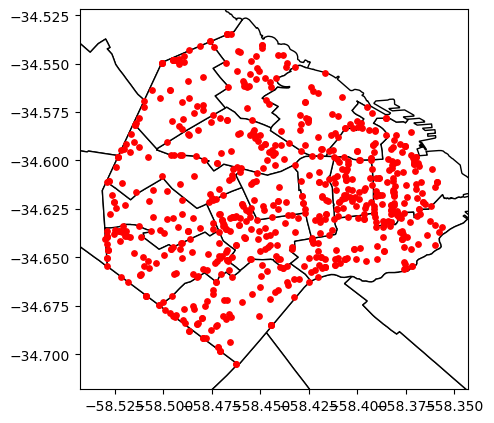

In [63]:
# Mapeamos las coordinadas de 'pos_x' y 'pos_y'
# Descartamos los nulos
df = df_homicidios.dropna(axis=0, subset=['pos x', 'pos y'])

# Create a GeoDataFrame with the geometry from the latitude and longitude
geometry = [Point(xy) for xy in zip(df['pos x'], df['pos y'])]
gdf = GeoDataFrame(df, geometry=geometry)

# Cargamos archivo SHX
ba_map = gpd.read_file('recursos/municipio.shx')

# Calculamos los limites del mapa
minx, miny, maxx, maxy = gdf.total_bounds

# Creamos los plots del mapa
fig, ax = plt.subplots(figsize=(5, 5))
ba_map.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

# Calculamos el margen del grafico
margin_ratio = 0.075
marginx = (maxx - minx) * margin_ratio
marginy = (maxy - miny) * margin_ratio
# Aplicamos los margenes en relacion a los plots en los extremos
ax.set_xlim(minx - marginx, maxx + marginx)
ax.set_ylim(miny - marginy, maxy + marginy)
plt.show()

## Análisis Temporal
Este analisis puede revelar patrones sobre cuándo ocurren siniestros viales. Ppor ejemplo, cantidad de accidentes durante las horas pico de tráfico, o durante la noche cuando la visibilidad es baja. También podría haber un aumento de accidentes en ciertas temporadas, dia de semana, etc.

### Tendencias y Estacionalidad

Visualizemos las cantidades de vistimas por fecha para ver si existen tendencias y estacionalidades.

In [64]:
# Creamos una grafica de barras de Victimas por Fecha
# Instanciamos un nuevo dataframe
df = pd.DataFrame()
# Create a new column for date bins
df['date_bin'] = pd.cut(df_homicidios['FECHA_HORA'], bins=80)
# Convertimos el formato de 'date_bin', para mostrar fechas como YYYY-MM
df['date_bin'] = df['date_bin'].apply(lambda x: f'{x.left.strftime("%Y-%m")}')
# Agrupamos por bins y contamos las filas
df_grouped = df.groupby('date_bin').size().reset_index(name='count')
# Creamos la grafica de barra
fig = px.bar(df_grouped, x='date_bin', y='count', labels={'date_bin':'Fecha', 'count':'Victimas'},
             title='Victimas por Fecha  (Estacionalidad y Tendencias)',)
fig.update_layout(autosize=False, width=700, height=350, template='plotly')
fig.show()

In [65]:
# Creamos una grafica de linea de Victimas por Fecha
# Instanciamos un nuevo dataframe
df = pd.DataFrame()
# Create a new column for date bins
df['date_bin'] = pd.cut(df_homicidios['FECHA_HORA'], bins=24)
# Convertimos el formato de 'date_bin', para mostrar fechas como YYYY-MM
df['date_bin'] = df['date_bin'].apply(lambda x: f'{x.left.strftime("%Y-%m")}')
# Agrupamos por bins y contamos las filas
df_grouped = df.groupby('date_bin').size().reset_index(name='count')
# Creamos la grafica de linea
fig = px.line(df_grouped, x='date_bin', y='count', labels={'date_bin':'Fecha', 'count':'Victimas'},
             title='Victimas por Fecha  (Estacionalidad y Tendencias)',)
fig.update_layout(autosize=False, width=700, height=350, template='plotly')
fig.show()

### Victimas por Franja Hora

In [66]:
# Creamos una grafica de victimas por hora
# Agrupamos victimas por franja hora
df_agrupado = df_homicidios.groupby('Franja_Hora')['N_VICTIMAS'].sum().reset_index()
fig = px.line(df_agrupado, x='Franja_Hora', y='N_VICTIMAS', title='Victimas por Franja Hora')
# Adjutamos el tamano
fig.update_layout(xaxis_title="Franja Hora", yaxis_title="Victimas", autosize=False, width=700, height=350, template='plotly')
fig.show()

In [67]:
# Creamos una grafica de victimas por Dia de Semana
# Agrupamos victimas por dia de semana
df_agrupado = df_homicidios.groupby('DIA_DE_SEMANA')['N_VICTIMAS'].sum().reset_index()
fig = px.line(df_agrupado, x='DIA_DE_SEMANA', y='N_VICTIMAS', title='Victimas por Dia de Semana')
# Adjutamos el tamano
fig.update_layout(xaxis_title="Dia de Semana", yaxis_title="Victimas", autosize=False, width=700, height=350, template='plotly')
fig.show()

In [68]:
# Creamos una grafica de victimas por mes
# Agrupamos victimas por mes
df_agrupado = df_homicidios.groupby('MES')['N_VICTIMAS'].sum().reset_index()
fig = px.line(df_agrupado, x='MES', y='N_VICTIMAS', title='Victimas por Mes')
# Adjutamos el tamano
fig.update_layout(xaxis_title="Mes", yaxis_title="Victimas",
                  autosize=False, width=700, height=350,
                  template='plotly')
fig.show()

In [69]:
# Creamos una grafica de victimas por estacion
# Agrupamos victimas por mes
df_agrupado = df_homicidios.groupby('Estaciones')[['N_VICTIMAS']].sum().reset_index()
fig = px.line(df_agrupado, x='Estaciones', y='N_VICTIMAS', title='Victimas por Estación')
# Adjutamos el tamano
fig.update_layout(xaxis_title="Estación", yaxis_title="Victimas",
                  autosize=False, width=700, height=350,
                  template='plotly')
fig.show()

In [70]:
# Creamos una grafica de victimas por Año
df_homicidios['AAAA'] = df_homicidios['AAAA'].astype(str)
# Agrupamos por Año y Victima
df_agrupado = df_homicidios.groupby(['AAAA', 'VICTIMA']).size().unstack()
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Año', yaxis_title='Victimas',
                  title='Victimas por Año, por Clasificación',
                  autosize=False, width=600, height=450,
                  legend=dict(x=1, y=1),
                  legend_title='Victima',
                  template='plotly'
)
fig.show()

In [71]:
# Agrupamos por 'Franja_Hora' y 'EDAD_GRUPO'
df_agrupado = df_homicidios.groupby(['Franja_Hora', 'EDAD_GRUPO']).size().unstack()
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Franja Hora', yaxis_title='Victimas',
                  title='Victimas por Franja Hora, por Grupo Etario',
                  autosize=False, width=600, height=450,
                  legend=dict(x=1, y=1),
                  legend_title='Grupo Etario',
                  template='plotly'
)
fig.show()

In [72]:
# Agrupamos por 'DIA_DE_SEMANA' y 'TIPO_DE_CALLE'
df_agrupado = df_homicidios.groupby(['DIA_DE_SEMANA', 'TIPO_DE_CALLE']).size().unstack()
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Franja Hora', yaxis_title='Victimas',
                  title='Victimas por Día de Semana y Tipo de Calle',
                  autosize=False, width=500, height=400,
                  legend=dict(x=1, y=1),
                  legend_title='Tipo de Calle',
                  template='plotly'
)
fig.show()

In [73]:
# Agrupamos por 'Franja_Hora' y 'TIPO_DE_CALLE'
df_agrupado = df_homicidios.groupby(['Franja_Hora', 'TIPO_DE_CALLE']).size().unstack()
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Franja Hora', yaxis_title='Victimas',
                  title='Victimas por Franja Hora, por Tipo de Calle',
                  autosize=False, width=500, height=400,
                  legend=dict(x=1, y=1),
                  legend_title='Tipo de Calle',
                  template='plotly'
)
fig.show()

## Análisis de Tabulación Cruzada

### Relación Victima-Acusado
Visualizemos las Victimas con relacion a los respetivo Acusados.

In [74]:
# Filtramos por victimas con mayor frecuancia, para no sobrecargar la grafica
acusado_filtro = ['AUTO','CARGAS','MOTO','OBJETO FIJO','PASAJEROS']
df = df_homicidios[df_homicidios['ACUSADO'].isin(acusado_filtro)]
# Agrupamos por ACUSADO y VICTIMA
df_agrupado = df.groupby(['VICTIMA','ACUSADO']).size().unstack()
# Sumamos las filas y aplicamos un sort
df_agrupado['suma'] = df_agrupado.sum(axis=1)
df_agrupado.sort_values('suma', ascending=False, inplace=True)
df_agrupado.drop(columns='suma', inplace=True)
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Clasificación Victima', yaxis_title='Victimas',
                  title='Victimas por Clasificación, con relación a Acusado',
                  autosize=False, width=650, height=500,
                  legend=dict(x=1, y=1),
                  legend_title='Acusado (top 5)',
                  template='plotly'
)
fig.show()

Proporción de los Top 5 Acusados 

In [75]:
# Creamos una grafica Pie-chart
# Filtramos por victimas con mayor frecuancia, para no sobrecargar la grafica
acusado_filtro = ['AUTO','CARGAS','MOTO','OBJETO FIJO','PASAJEROS']
df = df_homicidios[df_homicidios['ACUSADO'].isin(acusado_filtro)]
# Creamos la grafica
fig = go.Figure(data=[go.Pie(labels=df['ACUSADO'],
                             values=df['N_VICTIMAS'],
                             rotation=90,
                             textposition='outside'
)])
# Configuramos el layout
fig.update_layout(title='Proporción Top 5 Acusados',
                  autosize=False, width=500, height=380,
                  legend=dict(x=1, y=1),
                  legend_title='Acusado',
                  template='plotly'
)
fig.show()

### Relación Acusado-Victima
Visualizemos los Acusados con relacion a las Victimas afectadas.

In [76]:
# Filtramos por victimas con mayor frecuancia, para no sobrecargar la grafica
victima_filtro = ['AUTO','BICICLETA','MOTO','PEATON']
df = df_homicidios[df_homicidios['VICTIMA'].isin(victima_filtro)]
# Agrupamos por ACUSADO y VICTIMA
df_agrupado = df.groupby(['ACUSADO', 'VICTIMA']).size().unstack()
# Sumamos las filas y aplicamos un sort
df_agrupado['suma'] = df_agrupado.sum(axis=1)
df_agrupado.sort_values('suma', ascending=False, inplace=True)
df_agrupado.drop(columns='suma', inplace=True)
# Creamos una grafica de barras tipo stacked
fig = go.Figure(data=[
    go.Bar(name=col, x=df_agrupado.index, y=df_agrupado[col]) for col in df_agrupado.columns
])
# Configuramos el layout
fig.update_layout(barmode='stack', xaxis_title='Acusado', yaxis_title='Victimas',
                  title='Victimas por Acusado, con relación a Victimas',
                  autosize=False, width=650, height=500,
                  legend=dict(x=1, y=1),
                  legend_title='Victima (top 4)',
                  template='plotly'
)
fig.show()

In [77]:
# Creamos una grafica Pie-chart
# Filtramos por victimas con mayor frecuancia, para no sobrecargar la grafica
victima_filtro = ['AUTO','BICICLETA','MOTO','PEATON']
df = df_homicidios[df_homicidios['VICTIMA'].isin(victima_filtro)]
# Creamos la grafica
fig = go.Figure(data=[go.Pie(labels=df['VICTIMA'],
                             values=df['N_VICTIMAS'],
                             rotation=90,
                             textposition='outside'
)])
# Configuramos el layout
fig.update_layout(title='Proporción Top 4 Victimas',
                  autosize=False, width=500, height=380,
                  legend=dict(x=1, y=1),
                  legend_title='Victima',
                  template='plotly'
)
fig.show()

---

# 3. Conclusiones

En nuestro analisis observamos lo siguienetes hecho:
- La mayoria de las victimas son aproximadamente de 20 a 45 años de edad.
- Hay una cantidad de victimas disproporciónalmente alto de 42 años de edad.
- Hay una proporción mayor de victimas con Rol de Conductor.
- Dentro de victimas con rol de Conductor, la mayoria son jovenes del grupo etario de 21 a 40 \
victimas con rol de Conductor, la mayoria son jovenes del grupo etario de 21 a 40 
- Los Autos, vehiculos de Cargas y vehiculos de Pasajeros son los acusados mas frecuentes.
- La mayoria de las victimas outliers son peatones, con edades ≥ 83 años.